# Import package

In [71]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.octave import *
from qm.qua import *
from qm import generate_qua_script

#General os library 
import os
import time
import sys

sys.path.append(r"C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\QM_NonLinRes\Calibration_Script")
dll_path=r"C:\\Program Files\\Signal Hound\\Spike\\sa_api.dll"

import matplotlib.pyplot as plt
from qualang_tools.units import unit
from set_octave import get_L0_and_IF
from configuration import *
from qm import SimulationConfig, LoopbackInterface
from qualang_tools.units import unit
from qualang_tools.loops import from_array
u = unit()
from qualang_tools.plot import interrupt_on_close
from qualang_tools.results import progress_counter, fetching_tool
from qualang_tools.addons.variables import assign_variables_to_element

#Path for HQCPC7 
sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Analysis_Function\NonLinearRes')
sys.path.append(r'C:\Users\HQClabo\Documents\Code\QuantumMachine\Guillaume\NonLinearRes_calib_30_03_2023\Drivers\Drivers') #path for the analysis function


#from Signal_hound_driver import Signalhound 
from lmfit.models import LinearModel
from Signal_hound_driver import Signalhound 
import Calibration_function as calib
import update_config as cfg

#Path for HQC PC15 
# sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Analysis_Function\NonLinearRes')
# sys.path.append(r'C:\Users\hqclabo\Documents\Code\gbeaulieu\Drivers')
import AnFunc as an # analysis function
#import AnFunc as an 
import scipy.io
from scipy import signal 
from scipy.optimize import curve_fit

In [72]:
def update_readout_lenght(Readout_Len,config,qmm):
    """ Macro to update the readout length in the configuration file"""
    

    config["pulses"]["const"]["length"]=Readout_Len
    config["pulses"]["zero_pulse"]["length"]=Readout_Len
    config["integration_weights"]["cosine_weights"]["cosine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["cosine_weights"]["sine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["sine_weights"]["sine"][0]=(1.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["cosine"][0]=(0.0, Readout_Len)
    config["integration_weights"]["minus_sine_weights"]["sine"][0]=(-1.0, Readout_Len)


    #Update the config with the modified values above 
    qm = qmm.open_qm(config)
    
    return config, qm


def update_time_of_flight(time_of_flight,config,qmm):
    """ Update the time_of_flight of the qm in the configuration file """
    config["elements"]["resonator"]["time_of_flight"]=time_of_flight
    
    qm=qmm.open_qm(config)
    
    return config, qm

# Setting

In [84]:
#Octave & OPX configuration 
Saving_Path=r"\\sb1files\HQC\Users\beaulieu\Data\Run01\131\\"
Cooldown_Date="2023_07_10"

calibration_path='C:\\Users\\HQClabo\\Documents\\Code\\QuantumMachine\\Guillaume\\NonLinearRes_calib_30_03_2023\\QM_NonLinRes\\Calibration_Script'


opx_ip = '128.178.175.167'
opx_port = 81
octave_ip = '128.178.175.167'
octave_port = 53


octave_config = QmOctaveConfig()
octave_config.set_calibration_db(calibration_path) #Path to the calibration database 

octave_config.add_device_info('octave1', octave_ip, octave_port) #Add a device refered to as octave 1
octave_config.set_opx_octave_mapping([('con1', 'octave1')])  # set default mapping between analog outputs of OPX and the octave


qmm = QuantumMachinesManager(host=opx_ip, port=opx_port, octave=octave_config)
qm = qmm.open_qm(config)


#Mixers for the fluxline 
octave_output_gain=-10

#Mixers for the fluxline 
qmm.octave_manager.set_clock("octave1", ClockType.External, ClockFrequency.MHZ_10) # External clock on the octave 

qm.octave.set_lo_source("fluxline", OctaveLOSource.Internal) # Use internal LO for the fluxline 
qm.octave.set_lo_frequency("fluxline", LO_fluxline)  # Set the frequency of the LO 
qm.octave.set_rf_output_gain("fluxline", octave_output_gain)  # can set gain from -10dB to 20dB
qm.octave.set_rf_output_mode("fluxline", RFOutputMode.on)  # The LO output is always on (could change to a trigger)  #RFOutputMode.trig_normal

#Mixers for the resonator 
qm.octave.set_qua_element_octave_rf_in_port("resonator", "octave1", 1) #input port 1 is set for the resonator 
qm.octave.set_downconversion("resonator", lo_source=RFInputLOSource.Internal)  # The LO for the demodulation is the interal LO  

qm.octave.set_lo_source("resonator", OctaveLOSource.Internal) # Use internal LO for the fluxline 
qm.octave.set_lo_frequency("resonator", LO_readout)  # Set the frequency of the LO 
qm.octave.set_rf_output_gain("resonator", octave_output_gain)  # can set gain from -10dB to 20dB
qm.octave.set_rf_output_mode("resonator", RFOutputMode.on)  # The LO output is always on (could change to a trigger)RFOutputMode.trig_normal


offset_1= 0.01783981341796875
offset_2= 0.01553899095214844
config,qm=cfg.update_offset(offset_1, offset_2,config,qmm)

2023-08-28 13:47:54,513 - qm - INFO - Performing health check
2023-08-28 13:47:54,524 - qm - WARNING -   HC Warning: Potential hardware issue with QSync in controller con1, multiple controllers sync cannot be guaranteed, please inform QM
2023-08-28 13:47:54,525 - qm - INFO - Health check passed


In [85]:
print("LO of resonator : {} GHz".format(config['elements']['resonator']["mixInputs"]["lo_frequency"]/1e9))
print("IF of resonator : {} GHz".format(config['elements']['resonator']['intermediate_frequency']/1e9))
print("Time of flight of resonator : {} ns".format(config['elements']['resonator']['time_of_flight']))
print("Readout time resonator : {} ns".format(config["pulses"]["zero_pulse"]["length"]))
print("LO of fluxline: {} GHz".format(config['elements']['fluxline']["mixInputs"]["lo_frequency"]/1e9))
print("IF of fluxline : {} GHz".format(config['elements']['fluxline']['intermediate_frequency']/1e9))
print("Fluxline pulse time : {} ns".format(config["pulses"]["twoPhoton"]["length"]))
print("Fluxline amplitude : {} V".format(config["waveforms"]["twoPhoton_wf"]['sample']))

LO of resonator : 4.2 GHz
IF of resonator : 0.1 GHz
Time of flight of resonator : 296 ns
Readout time resonator : 500000 ns
LO of fluxline: 8.6 GHz
IF of fluxline : 0.0995 GHz
Fluxline pulse time : 10000 ns
Fluxline amplitude : 0.185 V


# Infinite pump

In [76]:
amp_factor=0.025

with program() as hello_octave:
    with infinite_loop_():
        play("cw"*amp(amp_factor), "resonator")
        
job = qm.execute(hello_octave)

2023-08-25 15:21:30,959 - qm - INFO - Flags: 
2023-08-25 15:21:30,959 - qm - INFO - Sending program to QOP
2023-08-25 15:21:31,180 - qm - INFO - Executing program


In [77]:
job.halt()

True

In [16]:
%matplotlib qt

#Sets the pulse length and the pulse amplitude at the resonator 
pulse_len=100_000
config,qm=update_readout_lenght(pulse_len,config,qmm)

time_of_flight=298//4*4 # minimum 24
config,qm=update_time_of_flight(time_of_flight,config,qmm)


amp_factor=0.05#Amplitude factor of the resonator 
n_avg = 100  # Number of averaging loops
cooldown_time = 100_000 // 4 #cooldown time between the averages in ns

with program() as raw_trace_prog:
   
    n = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    
    with for_(n, 0, n < n_avg, n + 1):
        measure(
            "cw"*amp(amp_factor),
            "resonator",
            None,
            dual_demod.full("cos", "out1", "sin", "out2", I),
            dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
        )

        wait(cooldown_time, "resonator")
        
        save(I, I_st)
        save(Q, Q_st)
            
    with stream_processing():

        I_st.save_all("I")
        Q_st.save_all("Q")

qm = qmm.open_qm(config)
job = qm.execute(raw_trace_prog)

results = fetching_tool(job, data_list=["I","Q"], mode="wait_for_all")

I, Q = results.fetch_all()

I = u.demod2volts(I, pulse_len)
Q = u.demod2volts(Q, pulse_len)

plt.figure()
plt.subplot(121)
plt.title("Single run")
plt.plot(I, label="I")
plt.plot(Q, label="Q")
plt.plot(np.sqrt(I**2+Q**2), label="Norm")
plt.xlabel("Time [ns]")
plt.ylabel("Signal amplitude [V]")
plt.legend()

print("The SNR on I : {}".format(np.mean(I)/np.sqrt(np.var(I))))
print("The SNR on Q : {}".format(np.mean(Q)/np.sqrt(np.var(Q))))
print("The SNR on total : {}".format(np.mean(np.sqrt(Q**2+I**2))/np.sqrt(np.var(np.sqrt(Q**2+I**2)))))

2023-08-24 11:38:26,217 - qm - INFO - Flags: 
2023-08-24 11:38:26,218 - qm - INFO - Sending program to QOP
2023-08-24 11:38:27,758 - qm - INFO - Executing program
The SNR on I : -12.819585851795377
The SNR on Q : 19.76296983728592
The SNR on total : 25.755455270753156


In [90]:
#Sets the pulse length and the pulse amplitude at the resonator 
pulse_len=500_000
config,qm=update_readout_lenght(pulse_len,config,qmm)

amp_factor=0.05
n_avg=500

cooldown_time=100_000

In [89]:
with program() as resonator_spec:

    n = declare(int)
    f = declare(int)
    I = declare(fixed)
    Q = declare(fixed)
    I_st = declare_stream()
    Q_st = declare_stream()
    n_st= declare_stream()

    with for_(n, 0, n < n_avg, n + 1):
        

        measure(
            "cw"*amp(amp_factor),
            "resonator",
            None,
            dual_demod.full("cos", "out1", "sin", "out2", I),
            dual_demod.full("minus_sin", "out1", "cos", "out2", Q),
        )

        wait(cooldown_time, "resonator") #Waiting time between sucessive measure 

        save(I, I_st)
        save(Q, Q_st)

    save(n, n_st)

    with stream_processing():

        I_st.save_all("I") #Fills all the buffer frequency and then average the sucessive 
        Q_st.save_all("Q")
        n_st.save("iteration")

simulate = False

if simulate:

    simulation_config = SimulationConfig(duration=10000)
    job = qmm.simulate(config, resonator_spec, simulation_config)
    job.get_simulated_samples().con1.plot(analog_ports={'1','2'},digital_ports={'1'})

else:

    qm = qmm.open_qm(config)
    job = qm.execute(resonator_spec)

    # Get results from QUA program
    results = fetching_tool(job, data_list=["I", "Q", "iteration"], mode="live")

    # Live plotting
    fig = plt.figure()

    while results.is_processing():
        # Fetch results
        I, Q, iteration = results.fetch_all()

            # Convert I & Q to Volts
        I = u.demod2volts(I, pulse_len)
        Q = u.demod2volts(Q, pulse_len)

        progress_counter(iteration, n_avg, start_time=results.get_start_time())

        # Plot results
        fig, ax = plt.subplots()
        ax.cla()
        ax.set_title("resonator spectroscopy amplitude")
        ax.plot(I, Q, ".")
        ax.set_xlabel("frequency [MHz]")
        ax.set_aspect('equal', 'box')
        print(np.mean(I**2+Q**2))
        
        # plt.ylabel(r"$\sqrt{I^2 + Q^2}$ [a.u.]")
        # plt.subplot(212)
        # plt.cla()
        # # detrend removes the linear increase of phase
        # phase = signal.detrend(np.unwrap(np.angle(I + 1j * Q)))
        # plt.title("resonator spectroscopy phase")
        # plt.plot(freqs / u.MHz, phase, ".")
        # plt.xlabel("frequency [MHz]")
        # plt.ylabel("Phase [rad]")
        # plt.pause(0.1)
        # plt.tight_layout()



2023-08-28 13:48:22,289 - qm - INFO - Flags: 
2023-08-28 13:48:22,290 - qm - INFO - Sending program to QOP
2023-08-28 13:48:30,813 - qm - INFO - Executing program
1.2043469932160278e-08#######################################] 100.2% (n=501/500) --> elapsed time: 0.03s


In [83]:
10*np.log10(1.5423127067606267e-06/(50*2)/(10**(-63.5/10)*1e-3))

15.381724366540565

## Time of fligh

In [41]:
%matplotlib qt

#Sets the pulse length and the pulse amplitude at the resonator 
pulse_len=1_000
config,qm=update_readout_lenght(pulse_len,config,qmm)
amp_factor=0.05

time_of_flight=298//4*4# minimum 
config,qm=update_time_of_flight(time_of_flight,config,qmm)


n_avg = 500  # Number of averaging loops
cooldown_time = 50_000 // 4 #cooldown time between the averages

with program() as raw_trace_prog:
    n = declare(int)
    adc_st = declare_stream(adc_trace=True)

    with for_(n, 0, n < n_avg, n + 1):
        reset_phase("resonator")
        measure("cw"*amp(amp_factor), "resonator", adc_st)
        wait(cooldown_time, "resonator")

    with stream_processing():
        
        # Will save average:
        adc_st.input1().average().save("adc1")
        adc_st.input2().average().save("adc2")
        
        # Will save only last run:
        adc_st.input1().save("adc1_single_run")
        adc_st.input2().save("adc2_single_run")

#Execute the program     
qm = qmm.open_qm(config)
job = qm.execute(raw_trace_prog)

results = fetching_tool(job, data_list=["adc1", "adc2", "adc1_single_run","adc2_single_run"], mode="wait_for_all")

adc1, adc2, adc1_single_run, adc2_single_run = results.fetch_all()

adc1 = u.raw2volts(adc1)
adc2 = u.raw2volts(adc2)
adc1_single_run = u.raw2volts(adc1_single_run)
adc2_single_run = u.raw2volts(adc2_single_run)

#Plotting 
plt.figure()
plt.subplot(121)
plt.title("Single run")
plt.plot(adc1_single_run, label="Input 1")
plt.plot(adc2_single_run, label="Input 2")
plt.xlabel("Time [ns]")
plt.ylabel("Signal amplitude [V]")
plt.legend()

plt.subplot(122)
plt.title("Averaged run")
plt.plot(adc1, label="Input 1")
plt.plot(adc2, label="Input 2")
plt.xlabel("Time [ns]")
plt.legend()
plt.tight_layout()

print("The mean offset of port 1 is: {}".format(np.mean(adc1)))
print("The mean offset of port 2 is: {}".format(np.mean(adc2)))

2023-08-18 11:04:35,160 - qm - INFO - Flags: 
2023-08-18 11:04:35,161 - qm - INFO - Sending program to QOP
2023-08-18 11:04:35,420 - qm - INFO - Executing program
The mean offset of port 1 is: -8.850341796875e-05
The mean offset of port 2 is: 0.00023778173828125


In [58]:
10*np.log10(0.0001544552313675362/5.011872336272725e-08
)

34.88802622353093

In [57]:
P_dbm=-43
P_W=10**(P_dbm/10)*1e-3
print(P_W)

5.011872336272725e-08


## from output to input

Amplitude  0.01
octave_output_gain=-10

We measure here, the signal from the QM into the qm with 10 averages (did'nt really influence) and vayring readout time. The cooldown is 100_000

In [150]:
Length_arr=[5000,10_000,50_000,100_000,250_000, 500_000]
            
value=[2.714855017361231e-06,2.8694800448648162e-06,2.999169958548127e-06,3.0118753340846953e-06,3.0236096981556156e-06, 3.018718997051703e-06]


Text(0, 0.5, '$<I^2>+<Q^2>$')

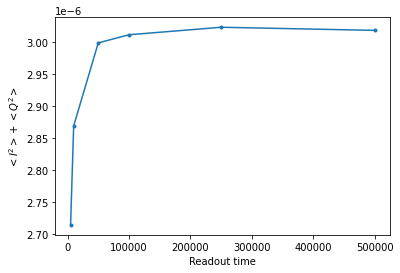

In [152]:
plt.plot(Length_arr, value,".-")
plt.xlabel("Readout time")
plt.ylabel(r"$<I^2>+<Q^2>$")

## from output to input with time of flight

In [230]:
Length_arr=[5000,10_000,50_000]
            
value=[3.0211282816249567e-06,3.022260570219558e-06,3.023617200436483e-06]

Text(0, 0.5, '$<I^2>+<Q^2>$')

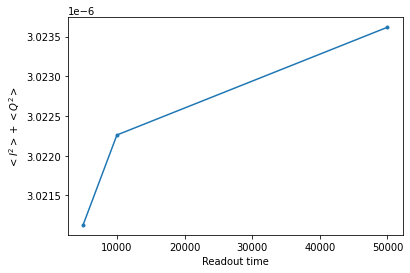

In [231]:
%matplotlib inline
plt.plot(Length_arr, value,".-")
plt.xlabel("Readout time")
plt.ylabel(r"$<I^2>+<Q^2>$")

## noise 

Then, we measure te noise, that is for an amplitude of 0. 

For 10_000 averages 

In [170]:
Length_arr=[500, 5000,10_000,50_000]

value=[1.572326499921605e-05, 1.4981785611866545e-06, 7.590447925652006e-07, 1.5403545448880595e-07]

Text(0.5, 1.0, 'vaccuum')

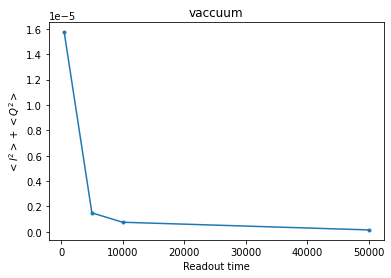

In [172]:
plt.plot(Length_arr, value,".-")
plt.xlabel("Readout time")
plt.ylabel(r"$<I^2>+<Q^2>$")
plt.title("vaccuum")

## Through the fridge

With an amplitude of 0.1 of amp_factor

In [191]:
Length_arr=[1000,5000,10_000,50_000,100_000]

value=[4.524681782229233e-05,7.46495062956552e-05, 7.902331721925492e-05,8.28229345370132e-05,8.343689207781229e-05]

Text(0, 0.5, '$<I^2>+<Q^2>$')

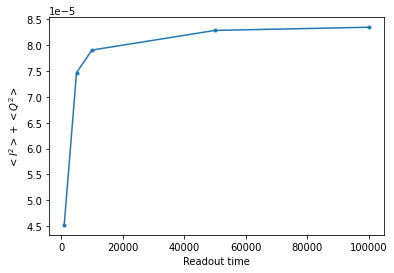

In [192]:
plt.plot(Length_arr, value,".-")
plt.xlabel("Readout time")
plt.ylabel(r"$<I^2>+<Q^2>$")

## Conversion :

We measuse the signal at the spectrum analyzer and then we measure the <I^2> + <Q^2> at the QM and find the conversion factor 

For the -60 dbm from the source at the Spectrum analyzer,we measured 

 At the spectrum analyzer, we get -63.08 dbm 
 
 For 10_000 : 1.6782355134937838e-06
 For 50_000: 1.6757923940010675e-06
 For 100_000 : 1.678669353024087e-06
 For 500_000 : 1.6726132757149207e-06

In [283]:
1.6726132757149207e-06/(50*2)

1.6726132757149205e-08

with, amp_factor=0.05  we get -44.50 dbm 
0.00013601248334004523

In [57]:
0.00013601248334004523/1.6782355134937838e-06

81.04493216026144

In [59]:
10*np.log10(81)

19.084850188786497

In [60]:
-63.08+19

-44.08